# Datasets (Sentiment) - Yelp - Categories

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
! pip install jsonlines

In [ ]:
! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

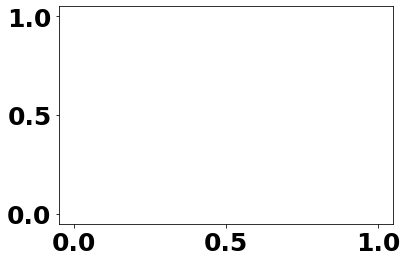

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [10]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

##### Make category comparisons

In [13]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [14]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij = businesses_i | businesses_j
            num_businesses_ij = len(businesses_ij)
            array_line.append(num_businesses_ij)
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [15]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [16]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:41, 160142.56it/s]


#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [17]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:01, 99711.99it/s] 
100%|██████████| 192127/192127 [00:00<00:00, 746625.66it/s]


#### Load category tree

- hierarchy of categories

In [18]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

---

#### Print category trees

In [19]:
print_category_tree(map_categories)

Active Life [active] [#99 children]
  ATV Rentals/Tours [atvrentals]
  Airsoft [airsoft]
  Amateur Sports Teams [amateursportsteams]
  Amusement Parks [amusementparks]
  Aquariums [aquariums]
  Archery [archery]
  Axe Throwing [axethrowing]
  Badminton [badminton]
  Baseball Fields [baseballfields]
  Basketball Courts [basketballcourts]
  Bathing Area [bathing_area]
  Batting Cages [battingcages]
  Beach Equipment Rentals [beachequipmentrental]
  Beach Volleyball [beachvolleyball]
  Beaches [beaches]
  Bicycle Paths [bicyclepaths]
  Bike Parking [bikeparking]
  Bike Rentals [bikerentals]
  Boating [boating]
  Bobsledding [bobsledding]
  Bocce Ball [bocceball]
  Bowling [bowling]
  Bubble Soccer [bubblesoccer]
  Bungee Jumping [bungeejumping]
  Canyoneering [canyoneering]
  Carousels [carousels]
  Challenge Courses [challengecourses]
  Climbing [climbing]
  Cycling Classes [cyclingclasses]
  Dart Arenas [dartarenas]
  Day Camps [daycamps]
  Disc Golf [discgolf]
  Diving [diving] [#2 chi

In [20]:
print_category_tree_with_num_businesses(map_categories, inv_cat_bids)

Active Life [active] . . . . . . . . . . . . . . . . . . . .  9521 businesses
  ATV Rentals/Tours [atvrentals] . . . . . . . . . . . . . .    51 businesses
  Airsoft [airsoft]. . . . . . . . . . . . . . . . . . . . .    16 businesses
  Amateur Sports Teams [amateursportsteams]. . . . . . . . .   217 businesses
  Amusement Parks [amusementparks] . . . . . . . . . . . . .   399 businesses
  Aquariums [aquariums]. . . . . . . . . . . . . . . . . . .    46 businesses
  Archery [archery]. . . . . . . . . . . . . . . . . . . . .    42 businesses
  Axe Throwing [axethrowing] . . . . . . . . . . . . . . . .    20 businesses
  Badminton [badminton]. . . . . . . . . . . . . . . . . . .    10 businesses
  Baseball Fields [baseballfields] . . . . . . . . . . . . .    14 businesses
  Basketball Courts [basketballcourts] . . . . . . . . . . .    17 businesses
  Bathing Area [bathing_area]. . . . . . . . . . . . . . . . No businesses associated!
  Batting Cages [battingcages] . . . . . . . . . . . . 

In [21]:
print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id)

Active Life [active] . . . . . . . . . . . . . . . . . . . .  9521 businesses
  ATV Rentals/Tours [atvrentals] . . . . . . . . . . . . . .    51 businesses
  Airsoft [airsoft]. . . . . . . . . . . . . . . . . . . . .    16 businesses
  Amateur Sports Teams [amateursportsteams]. . . . . . . . .   217 businesses
  Amusement Parks [amusementparks] . . . . . . . . . . . . .   399 businesses
  Aquariums [aquariums]. . . . . . . . . . . . . . . . . . .    46 businesses
  Archery [archery]. . . . . . . . . . . . . . . . . . . . .    42 businesses
  Axe Throwing [axethrowing] . . . . . . . . . . . . . . . .    20 businesses
  Badminton [badminton]. . . . . . . . . . . . . . . . . . .    10 businesses
  Baseball Fields [baseballfields] . . . . . . . . . . . . .    14 businesses
  Basketball Courts [basketballcourts] . . . . . . . . . . .    17 businesses
  Bathing Area [bathing_area]. . . . . . . . . . . . . . . . No businesses associated!
  Batting Cages [battingcages] . . . . . . . . . . . . 

In [22]:
print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id)

Active Life [active] . . . . . . . . . . . . . . .  9521 businesses
Arts & Entertainment [arts]  . . . . . . . . . . .  6304 businesses
Automotive [auto]  . . . . . . . . . . . . . . . . 13203 businesses
Beauty & Spas [beautysvc]  . . . . . . . . . . . . 19370 businesses
Bicycles [bicycles]  . . . . . . . . . . . . . . .     9 businesses
Education [education]  . . . . . . . . . . . . . .  3314 businesses
Event Planning & Services [eventservices]  . . . . 10371 businesses
Financial Services [financialservices] . . . . . .  3082 businesses
Food [food]  . . . . . . . . . . . . . . . . . . . 29989 businesses
Health & Medical [health]  . . . . . . . . . . . . 17171 businesses
Home Services [homeservices] . . . . . . . . . . . 19744 businesses (self: 19729)
Hotels & Travel [hotelstravel] . . . . . . . . . .  6033 businesses
Local Flavor [localflavor] . . . . . . . . . . . .  1444 businesses
Local Services [localservices] . . . . . . . . . . 13932 businesses
Mass Media [massmedia] . . . . . .

In [23]:
print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id)

Bicycles [bicycles]  . . . . . . . . . . . . . . .     9 businesses
Mass Media [massmedia] . . . . . . . . . . . . . .   319 businesses
Religious Organizations [religiousorgs]  . . . . .   547 businesses
Public Services & Government [publicservicesgovt]   1343 businesses
Local Flavor [localflavor] . . . . . . . . . . . .  1444 businesses
Financial Services [financialservices] . . . . . .  3082 businesses
Education [education]  . . . . . . . . . . . . . .  3314 businesses
Pets [pets]  . . . . . . . . . . . . . . . . . . .  4111 businesses
Hotels & Travel [hotelstravel] . . . . . . . . . .  6033 businesses
Professional Services [professional] . . . . . . .  6276 businesses
Arts & Entertainment [arts]  . . . . . . . . . . .  6304 businesses
Active Life [active] . . . . . . . . . . . . . . .  9521 businesses
Event Planning & Services [eventservices]  . . . . 10371 businesses
Nightlife [nightlife]  . . . . . . . . . . . . . . 13095 businesses
Automotive [auto]  . . . . . . . . . . . . . . .

In [ ]:
### TEST ###
# because ``inv_cat_bids`` contained duplicate ids!
businesses = inv_cat_bids["Food"]
print(f"""Food: {len(businesses)}, {len(set(businesses))}""")

businesses_cnt = Counter(businesses)
businesses_cnt.most_common(10)

# inv_bid_cats["UupxKYWMnE6uq_eELO4CBQ"]
# [(c, [bi for bi in b if bi == "UupxKYWMnE6uq_eELO4CBQ"]) for c, b in inv_cat_bids.items() if "UupxKYWMnE6uq_eELO4CBQ" in b]

##### Overlap of businesses (ids) for two categories

In [24]:
businesses_food = get_businesses_in_category_branch(inv_cat_bids, "Food", map_categories, map_cat_name2id)
businesses_restaurants = get_businesses_in_category_branch(inv_cat_bids, "Restaurants", map_categories, map_cat_name2id)

print(f"""Food:        {len(set(businesses_food)):>5d}""")
print(f"""Restaurants: {len(set(businesses_restaurants)):>5d}""")
print(f"""Both:  same: {len(set(businesses_food) & set(businesses_restaurants)):>5d}""")
print(f"""      total: {len(set(businesses_food) | set(businesses_restaurants)):>5d}""")
print()

print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, "Food", "Restaurants")

Food:        29989
Restaurants: 59371
Both:  same: 14800
      total: 74560

Food:        29989
Restaurants: 59371
Both:  same: 14800
      total: 74560


In [ ]:
root_categories = get_root_category_items(map_categories)

#### Category overlap heatmap

In [25]:
category_overlap_array, root_category_labels, df_cm = make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id)

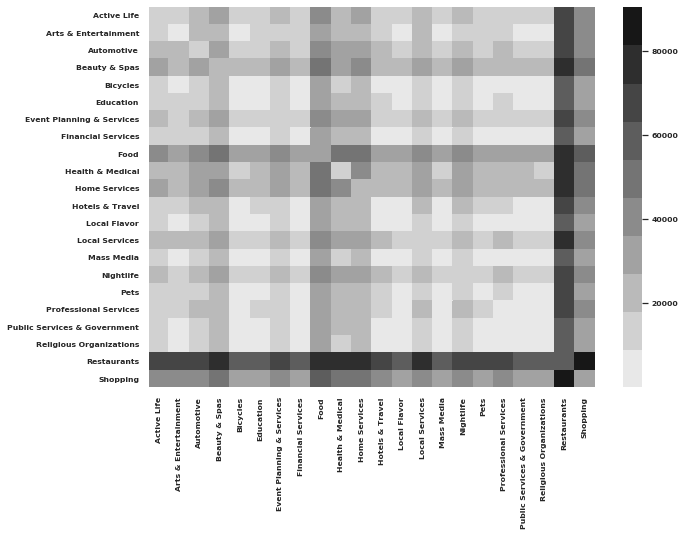

In [26]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}, cmap=sn.color_palette("binary", 10)) # font size
plt.show()

<Figure size 1152x1152 with 0 Axes>

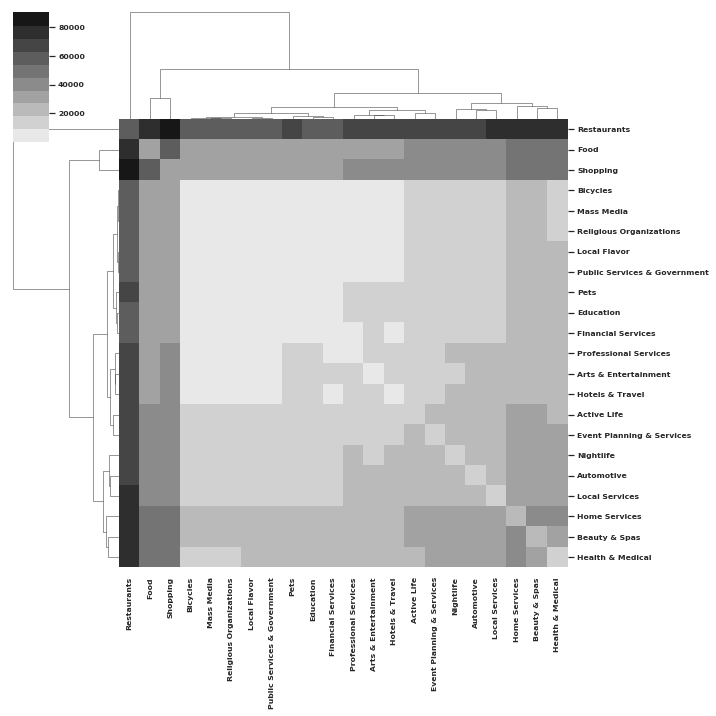

In [27]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 10)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

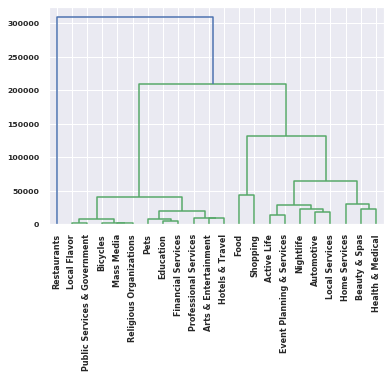

In [28]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

---

In [29]:
df_food = get_reviews_for_category(df, "Food", inv_cat_bids, map_categories, map_cat_name2id)

Food: 72013, uniq: 29989


In [30]:
# min ratings per class (good|bad)
min_ratings = 5

df_food = filter_min_review_freq(df_food, min_ratings=5)

In [31]:
tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

df_food = df_food.progress_apply(tokenize_text, axis=1)

100%|██████████| 1368084/1368084 [24:25<00:00, 933.71it/s] 


In [32]:
def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

df_food = df_food.progress_apply(count_words, axis=1)

100%|██████████| 1368084/1368084 [14:11<00:00, 1606.84it/s]


In [33]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368084 entries, 6 to 6685899
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1368084 non-null  object 
 1   rid        1368084 non-null  object 
 2   text       1368084 non-null  object 
 3   rating     1368084 non-null  float64
 4   goodness   1368084 non-null  bool   
 5   text_tok   1368084 non-null  object 
 6   num_words  1368084 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 74.4+ MB


In [36]:
df_food.describe()

,rating,num_words
count,1.368084e+06,1.368084e+06
mean,3.821394e+00,1.211499e+02
std,1.343250e+00,1.116265e+02
min,1.000000e+00,1.000000e+00
25%,3.000000e+00,4.800000e+01
50%,4.000000e+00,8.600000e+01
75%,5.000000e+00,1.560000e+02
max,5.000000e+00,1.203000e+03


In [43]:
df_food["num_words"].mean()

121.14985848822148

---

---

---

### Filter all reviews - can only contain top50 Topics

In [ ]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
f_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats)
f_inv_cat_bids = make_map_cats(f_inv_bid_cats)
f_inv_cat_combis = make_cat_combis(f_inv_bid_cats)
f_cat_pairs = make_cat_Ntuples(f_inv_cat_combis, n=2)

### Filter with minimum number of category combination occurrences

In [ ]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
# f_cats = None

avg_num_of_cat_combis = int(sum(list(f_inv_cat_combis.values())) / len(f_inv_cat_combis))
fi_inv_cat_combis = filter_min_cat_combis(inv_cat_combis, min_num=30)

f2_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats, filter_cat_combis=fi_inv_cat_combis)

f2_inv_cat_bids = make_map_cats(f2_inv_bid_cats)
f2_inv_cat_combis = make_cat_combis(f2_inv_bid_cats)
f2_cat_pairs = make_cat_Ntuples(f2_inv_cat_combis, n=2)

### Make NxN map and heatmap it

In [ ]:
df_cm, cat_array, cat_labels = make_NxN_map(f_cats, f2_cat_pairs)

#### Clustering

In [ ]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}) # font size
plt.show()

In [ ]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 10)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

In [ ]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [ ]:
df_cm2 = ssd.squareform(df_cm)

Z = hierarchy.linkage(df_cm2, "ward")
hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [ ]:
sc = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
cluster_labels = sc.fit_predict(cat_array)

# sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

In [ ]:
ac = AgglomerativeClustering(4, affinity='euclidean', linkage='ward')
csarr = cosine_similarity(cat_array)
cluster_labels = ac.fit_predict(csarr)

# sorted(list(zip(labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

In [ ]:
# cat_array, \
# linear_kernel(cat_array), \
# cosine_similarity(cat_array), \
# cat_labels

### Stats for `cat_labels` in filtered category maps/lists etc.

In [ ]:
# number of business ids given a specific category
sorted([(c, len(f_inv_cat_bids[c])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f2_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# better with filtering
# category pairs for a given category
sorted([(c, [cc for cc in f2_cat_pairs.keys() if c in cc]) for c in cat_labels], key=lambda x: len(x[1]), reverse=True)[:5]

In [ ]:
# category pairs for a category:
c = "Food"

print("filtered by top50\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f_cat_pairs.keys() if c in cc]])
print()
print("filtered by avg amount (+top50)\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f2_cat_pairs.keys() if c in cc]])

In [ ]:
f2_inv_cat_combis[("Food",)]  # businesses with only this category ... (filtering should not affect this value)

In [ ]:
f2_inv_cat_combis

In [ ]:
inv_bid_cats = f2_inv_bid_cats
inv_cat_bids = f2_inv_cat_bids
inv_cat_combis = f2_inv_cat_combis
cat_pairs = f2_cat_pairs

In [ ]:
sum([len(b) for a, b in f2_inv_cat_bids.items()])

In [ ]:
inv_bid_cats = load_topics(fn_yelp_topics)
sum([len(b) for a, b in inv_cat_bids.items()])

In [ ]:
https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
len(f2_inv_cat_combis)  # number of category combinations

---

#### Statistics

In [ ]:
print(f"Number of businesses with categories: {len(inv_bid_cats):>6}")
print(f"                  without categories: {len(bids_not_cats):>6}")
print(f"Number of categories: len(inv_cat_bids) = {len(inv_cat_bids)}")

In [ ]:
inv_cat_combis.most_common(20)

In [ ]:
# count single categories
cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
cnt.most_common(20)

#### Filter reviews with at least N ratings

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df = filter_min_review_freq(df, min_ratings=5)

#### Filter only reviews with both good and bad rating

In [ ]:
df = filter_both_good_bad(df)

#### Make pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [ ]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [ ]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

In [ ]:
pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)

print("#ss (pos)", len(pairs_good))
print("#ss (neg)", len(pairs_bad))

##### not same-sentiment pairs (combinations positive + negative)

In [ ]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [ ]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

In [ ]:
pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)

print("#nss", len(pairs_not_ss))

##### dataframe for training etc.

In [ ]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if os.path.exists(fn_yelp_df):
        with open(fn_yelp_df, "rb") as fp:
            all_df = pickle.load(fp)
        return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    with open(fn_yelp_df, "wb") as fp:
        pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

In [ ]:
pairs_all = pairs_good + pairs_bad + pairs_not_ss
print("#~ss", len(pairs_all))

# print(pairs_all[0]["argument1_id"])
np.random.shuffle(pairs_all)
# print(pairs_all[0]["argument1_id"])

df_traindev = pd.DataFrame.from_dict(pairs_all)

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "wb") as fp:
    pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Reloading for training

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

In [ ]:
# len(traindev_df), len(test_df)